In [1]:
from tensorflow.keras.layers import LSTM, Dense, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib
import datetime
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pyupbit

In [2]:
coins = ['KRW-BTC', 'KRW-ETH', 'KRW-DOGE', 'KRW-BIGTIME', 'KRW-SUI', 'KRW-UXLINK', 'KRW-SOL', 'KRW-XRP', 'KRW-SXP']

In [3]:
len(coins)

9

In [4]:
interval = 'minute1'
count = 60 * 24 * 365 * 2

In [5]:
timestep = 1
window_size = 5
col_list = ['open', 'high', 'low', 'volatility', 'avg_change_rate', 'percentage_change', 'close_change', 'close']
n_features = len(col_list)

In [6]:
def inverse_transform_predictions(preds, scaler, label_idx=-1):
    dummy = np.zeros((len(preds), scaler.n_features_in_))
    dummy[:, label_idx] = preds[:, 0]
    return scaler.inverse_transform(dummy)[:, label_idx]

In [7]:
def get_percentage(future, past):
    return (future - past) / past * 100

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, n_features)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

KRW-BTC data loaded
KRW-BTC train start
6629/6629 [==============================] - 10s 1ms/step
KRW-BTC Train RMSE: 0.000359 Validation RMSE: 0.008738
1/1 [==============================] - 0s 15ms/step
KRW-BTC Actual 146622000.000000 Pred 143243772.804439
.
KRW-ETH data loaded
KRW-ETH train start
6629/6629 [==============================] - 10s 1ms/step
KRW-ETH Train RMSE: 0.001091 Validation RMSE: 0.001331
1/1 [==============================] - 0s 12ms/step
KRW-ETH Actual 5184000.000000 Pred 5180376.621157
.
KRW-DOGE data loaded
KRW-DOGE train start
6628/6628 [==============================] - 9s 1ms/step
KRW-DOGE Train RMSE: 0.000697 Validation RMSE: 0.059614
1/1 [==============================] - 1s 578ms/step
KRW-DOGE Actual 488.900000 Pred 460.611178
.
KRW-BIGTIME data loaded
KRW-BIGTIME train start
918/918 [==============================] - 1s 1ms/step
KRW-BIGTIME Train RMSE: 0.001962 Validation RMSE: 0.007196
1/1 [==============================] - 0s 13ms/step
KRW-BIGTIME Act

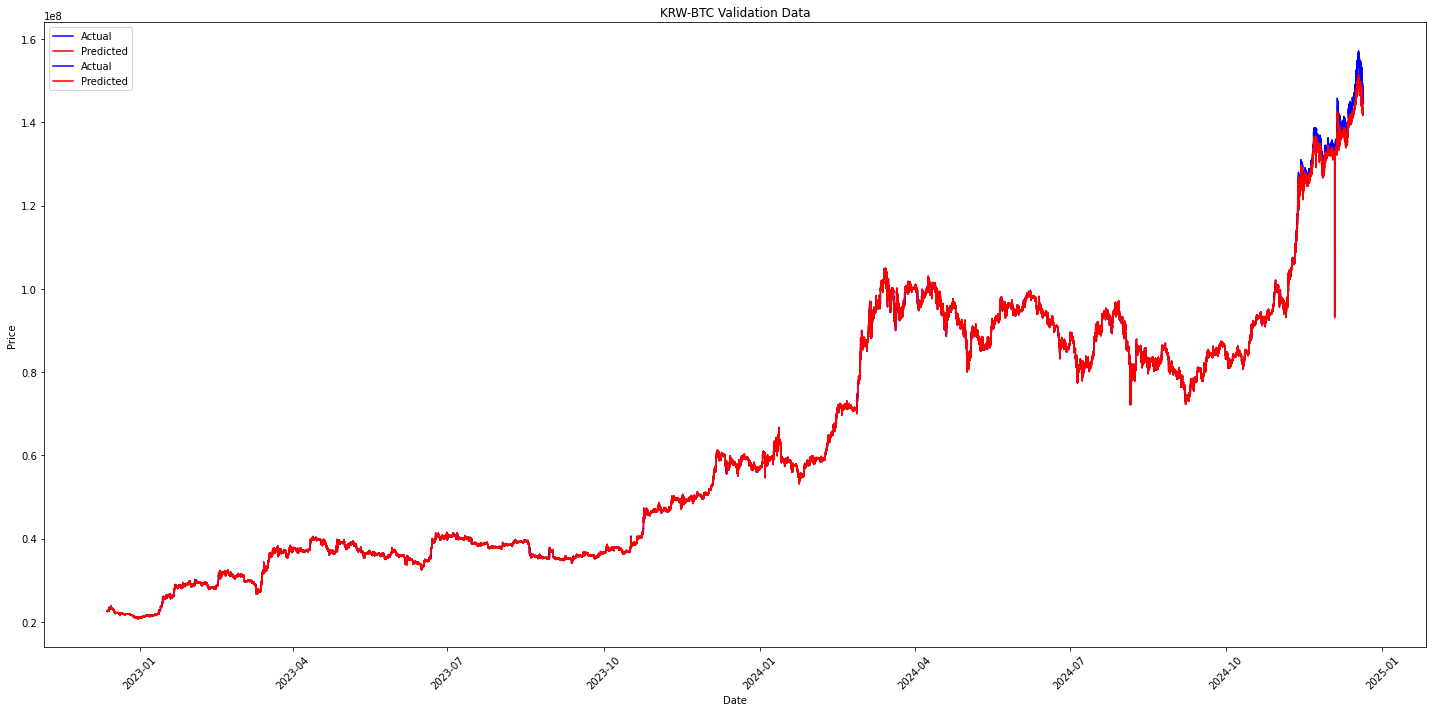

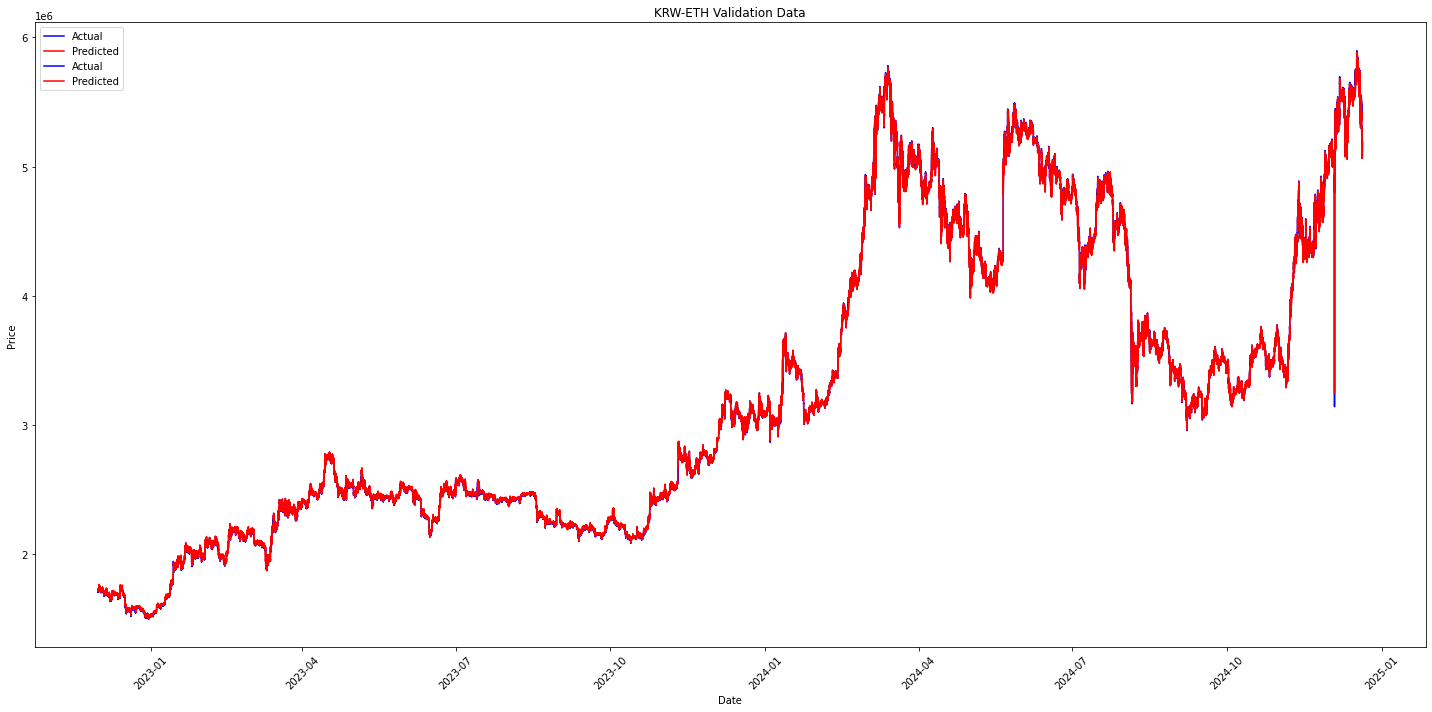

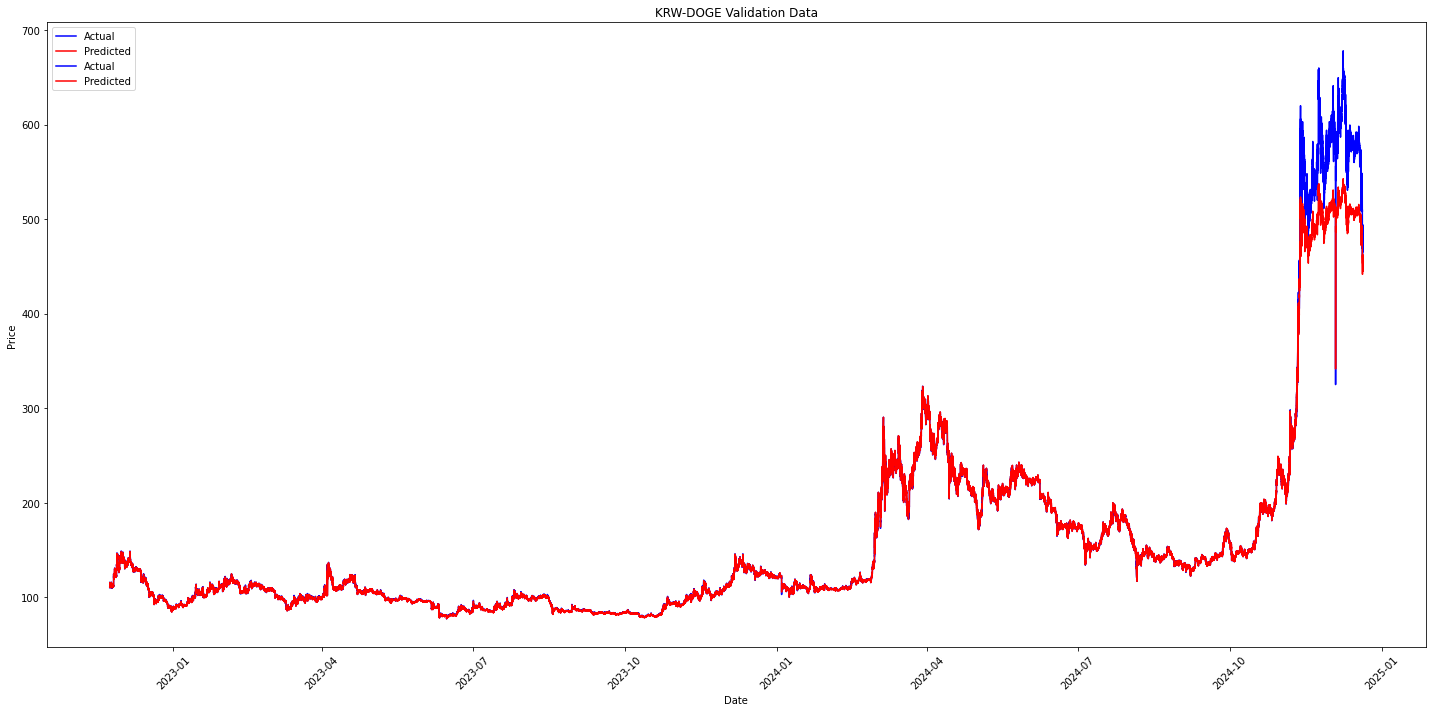

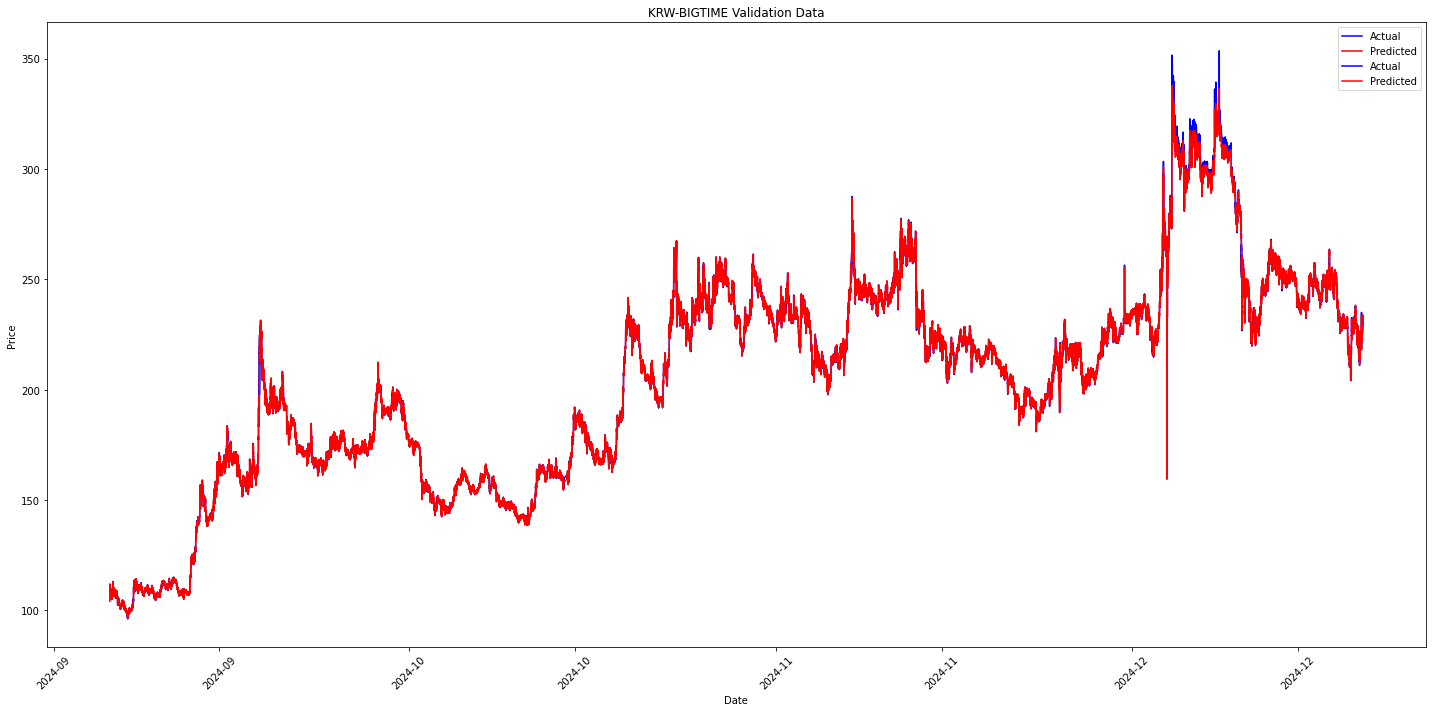

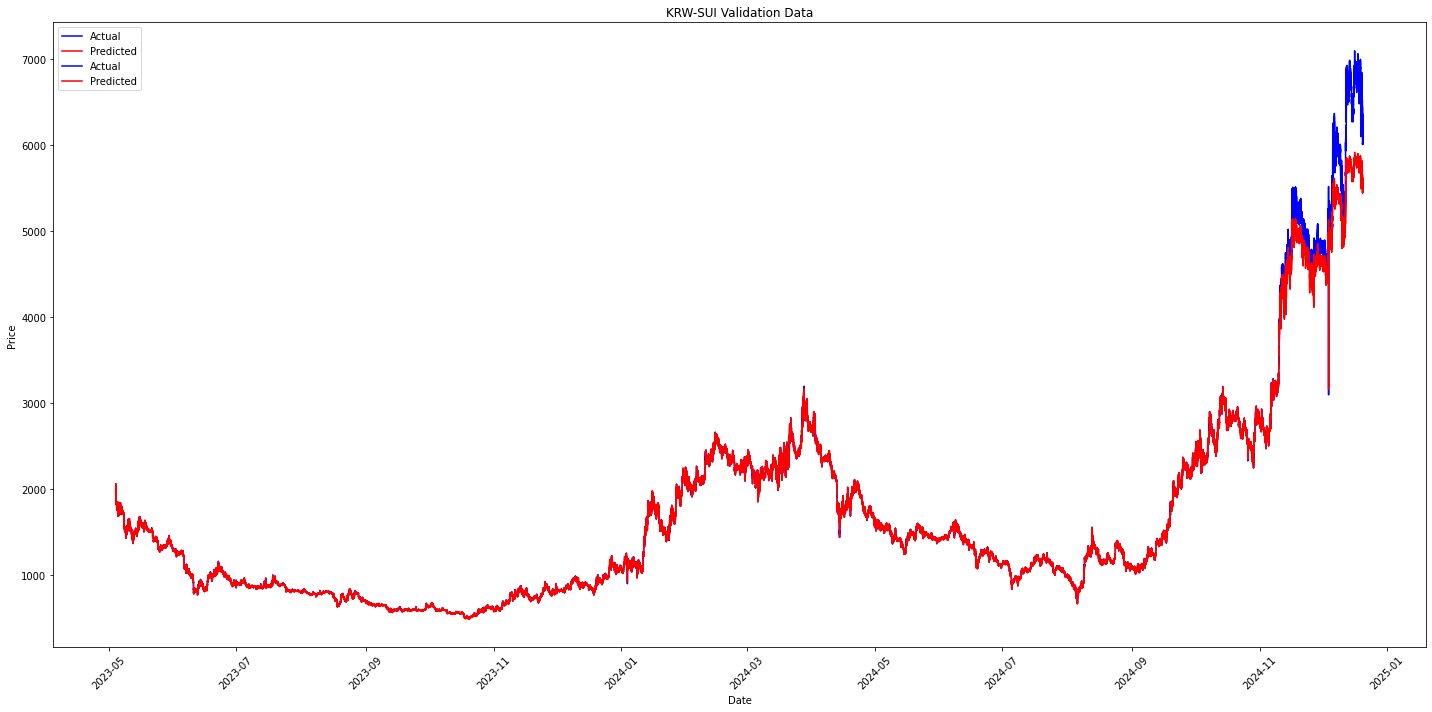

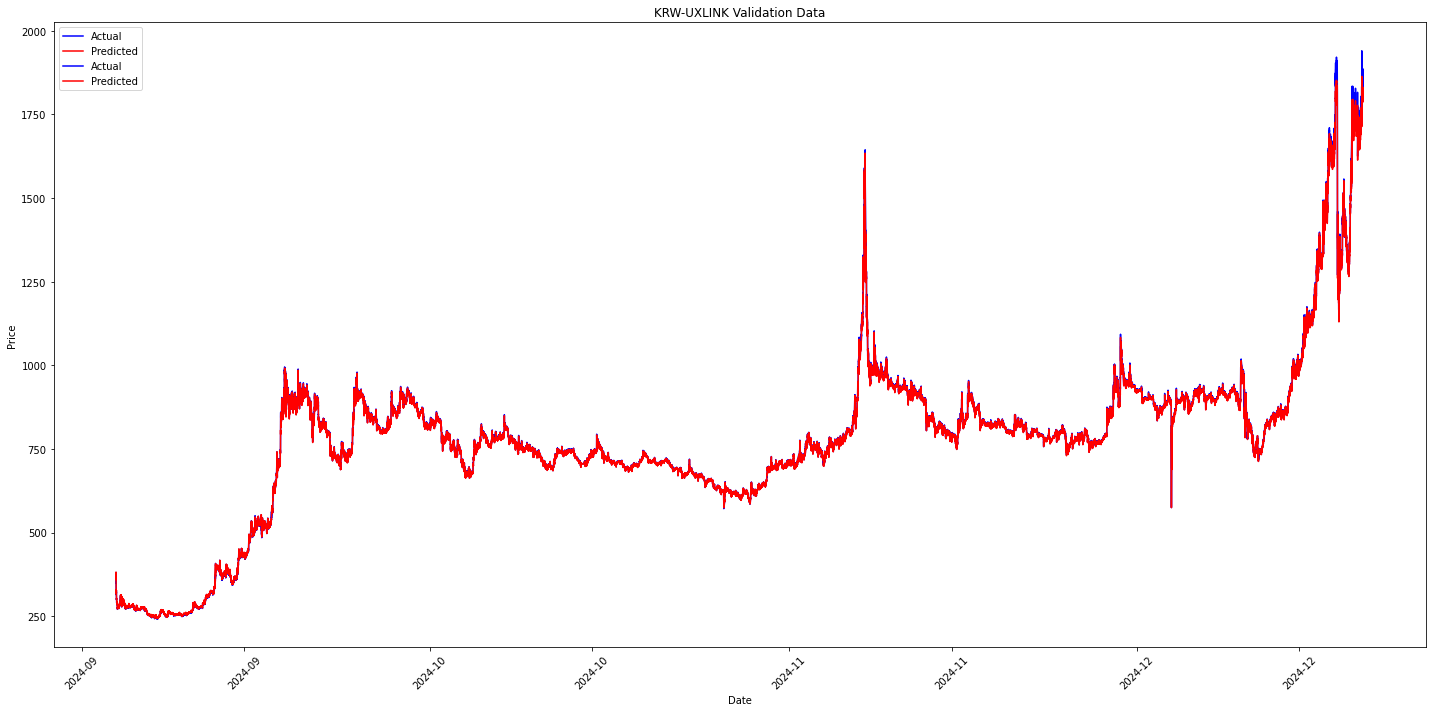

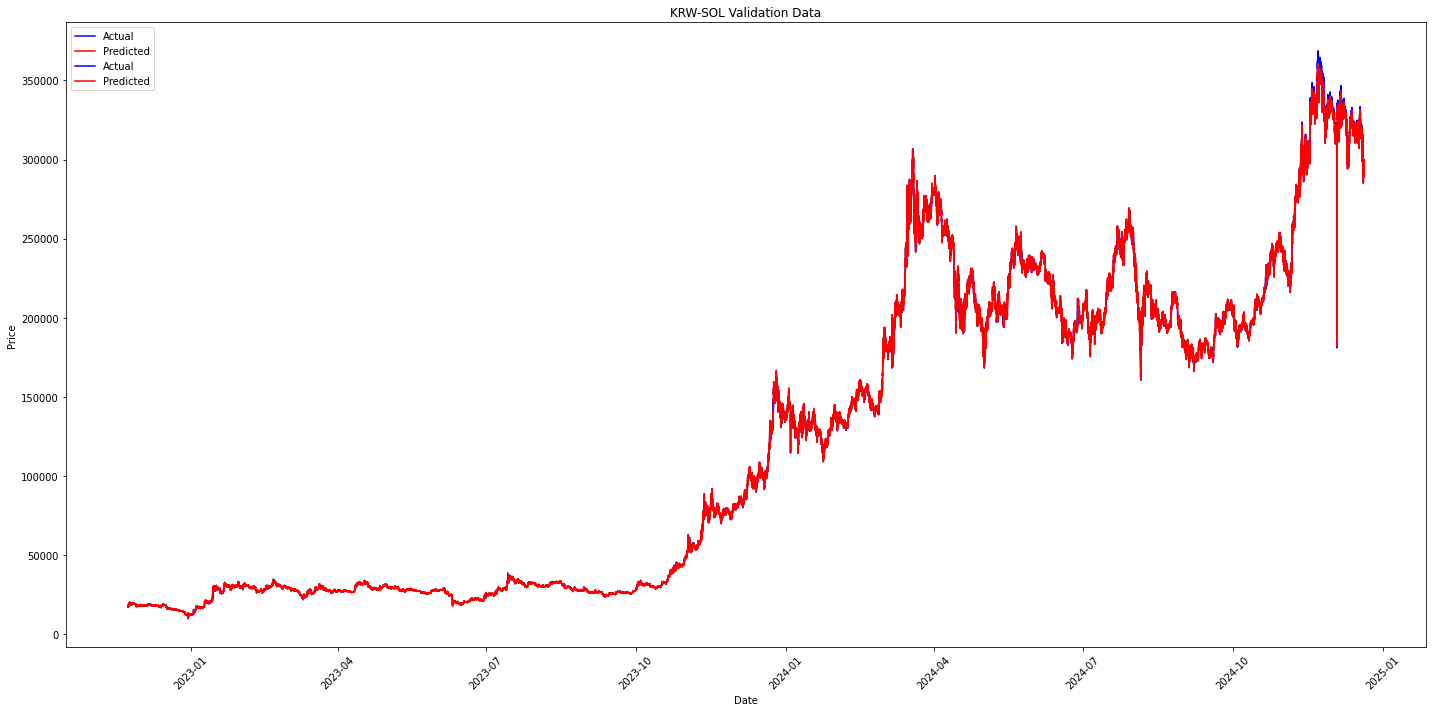

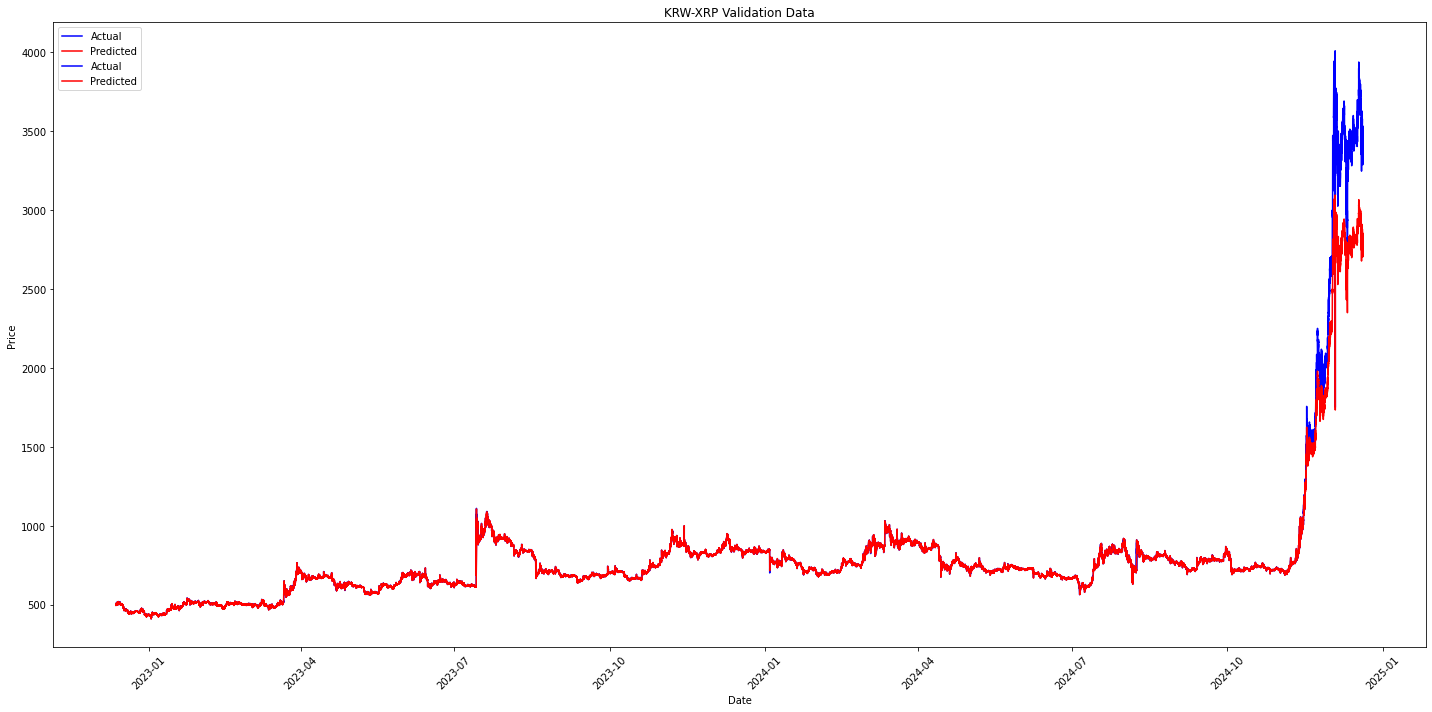

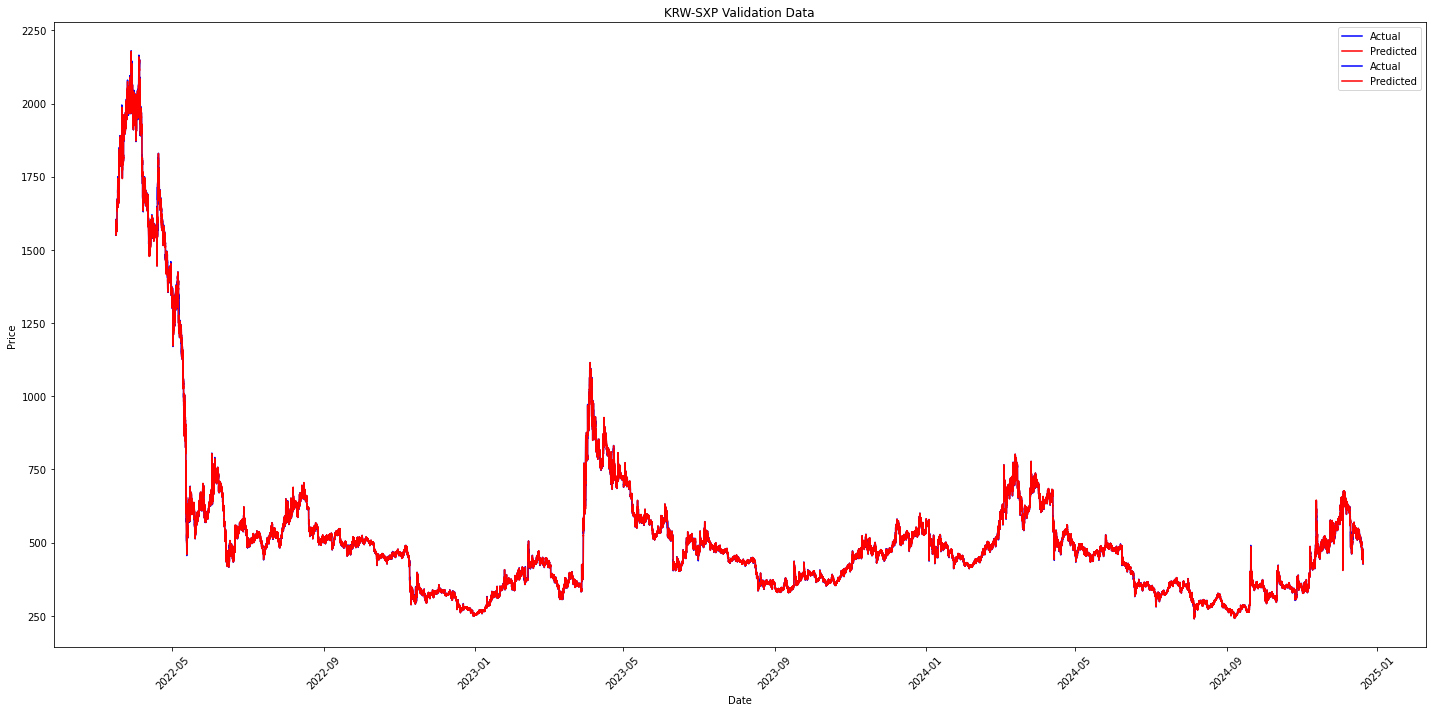

In [9]:
for ticker in coins:
    df = pd.read_csv(f'../../data/from_pyupbit/{ticker}.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    df['close_change'] = df['close'].diff().fillna(0)
    
    df.set_index('timestamp', inplace=True)
    
    df['percentage_change'] = get_percentage(df['close'], df['close'].shift(1)).fillna(0)
    df['volatility'] = df['percentage_change'].rolling(window=5).std()
    df['avg_change_rate'] = df['percentage_change'].rolling(window=5).mean()
    
    df = df[col_list].fillna(0)
    
    print(f'{ticker} data loaded')
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    scaled_data = scaler.fit_transform(df)
    joblib.dump(scaler, f'models/fewer/{ticker}_scaler.pkl')
    
    X = []
    y = []
    for i in range(len(scaled_data) - timestep):
        X.append(scaled_data[i:(i + timestep), :])
        y.append(scaled_data[i + timestep, -1])
    
    X, y = np.array(X), np.array(y)
    
    train_size = int(len(df) * .8)
    X_train, X_val = X[:train_size], X[train_size:] # n_samples, timestep, n_features
    y_train, y_val = y[:train_size], y[train_size:]
    
    train_dates = df.index[:train_size]
    val_dates = df.index[train_size:]
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='loss', patience=10)
    
    print(f'{ticker} train start')
    
    model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
    model.save(f'models/fewer/lstm_{ticker}.h5')
    
    train_predict = model.predict(X_train)
    val_predict = model.predict(X_val)
    
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    val_score = np.sqrt(mean_squared_error(y_val, val_predict))
    print(f'{ticker} Train RMSE: {train_score:.6f} Validation RMSE: {val_score:.6f}')
    
    train_predict_original = inverse_transform_predictions(train_predict, scaler)
    val_predict_original = inverse_transform_predictions(val_predict, scaler)
    y_train_original = inverse_transform_predictions(y_train.reshape(-1, 1), scaler)
    y_val_original = inverse_transform_predictions(y_val.reshape(-1, 1), scaler)
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 1, 1)
    plt.plot(train_dates, y_train_original, label='Actual', color = 'Blue')
    plt.plot(train_dates, train_predict_original, label='Predicted', color = 'Red')
    plt.title(f'{ticker} Train Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
    plt.savefig(f'results/fewer/{ticker}_train.png')
    
    plt.subplot(1, 1, 1)
    plt.plot(val_dates[:-1], y_val_original, label='Actual', color = 'Blue')
    plt.plot(val_dates[:-1], val_predict_original, label='Predicted', color = 'Red')
    plt.title(f'{ticker} Validation Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.savefig(f'results/fewer/{ticker}_val.png')
    
    last_1_day = scaled_data[-timestep:]
    X_test = last_1_day[-1, :].reshape(1, timestep, n_features)
    pred = model.predict(X_test)
    pred = inverse_transform_predictions(pred, scaler)
    print(f'{ticker} Actual {scaler.inverse_transform(last_1_day)[-1, -1]:.6f} Pred {pred[0]:.6f}')
    print('.')